<a href="https://colab.research.google.com/github/vini-castro/sidewalk_depthanything/blob/colab/sidewalk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -m pip install pyyaml==5.1 -q
import sys, os, distutils.core

# Clonar o repositório detectron2 e sidewalk-depthanything
!git clone 'https://github.com/facebookresearch/detectron2' -q
!git clone 'https://github.com/vini-castro/sidewalk_depthanything' -q

# Instalar dependências do detectron2
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])} -q

# Adicionar detectron2 ao sys.path
sys.path.insert(0, os.path.abspath('./detectron2'))

# Verificar a versão do CUDA
!nvcc --version

# Imprimir versões de torch e detectron2
import torch, detectron2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch:", TORCH_VERSION, "; cuda:", CUDA_VERSION)
print("detectron2:", detectron2.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 15.1 MB/s

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Run a pre-trained detectron2 model

We first download an image from the COCO dataset:

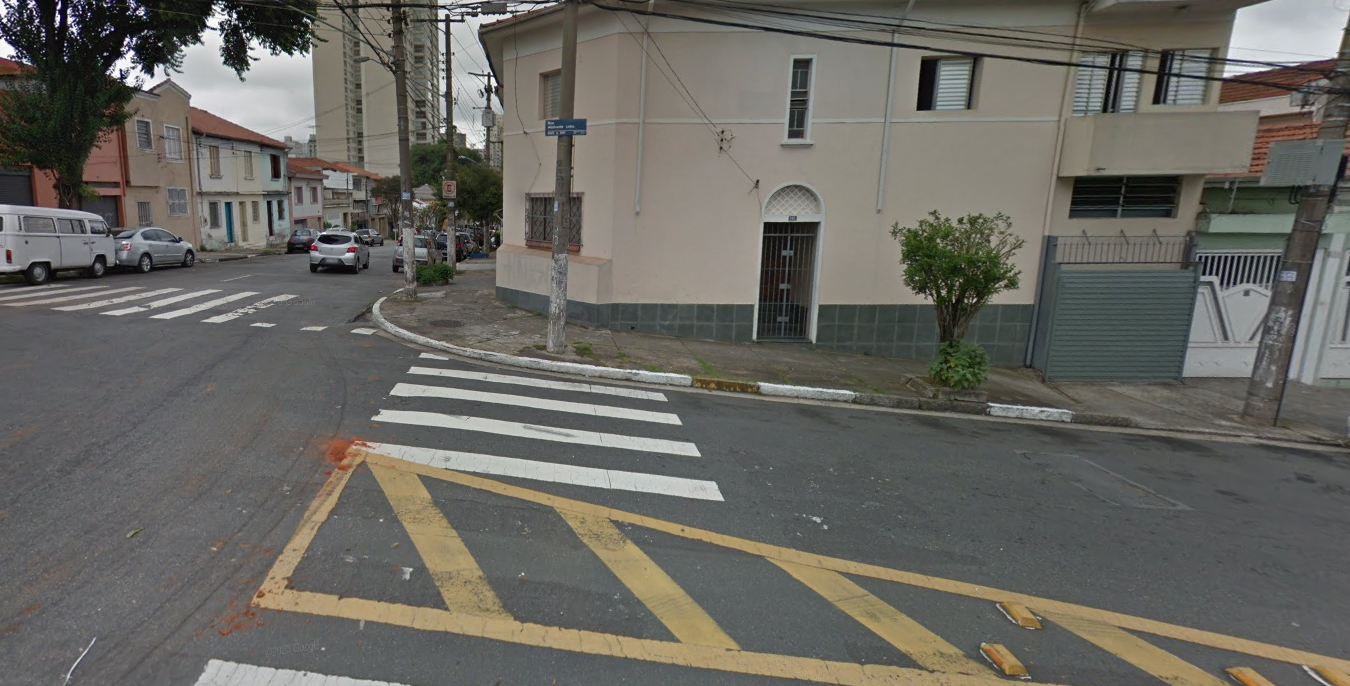

In [ ]:
im = cv2.imread("./sidewalk_depthanything/assets/examples/Demo1.png")
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

[04/04 01:06:13 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:04, 64.5MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[11, 11, 11,  ..., 12, 12, 12],
        [11, 11, 11,  ..., 12, 12, 12],
        [11, 11, 11,  ..., 12, 12, 12],
        ...,
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10],
        [10, 10, 10,  ..., 10, 10, 10]], dtype=torch.int32)


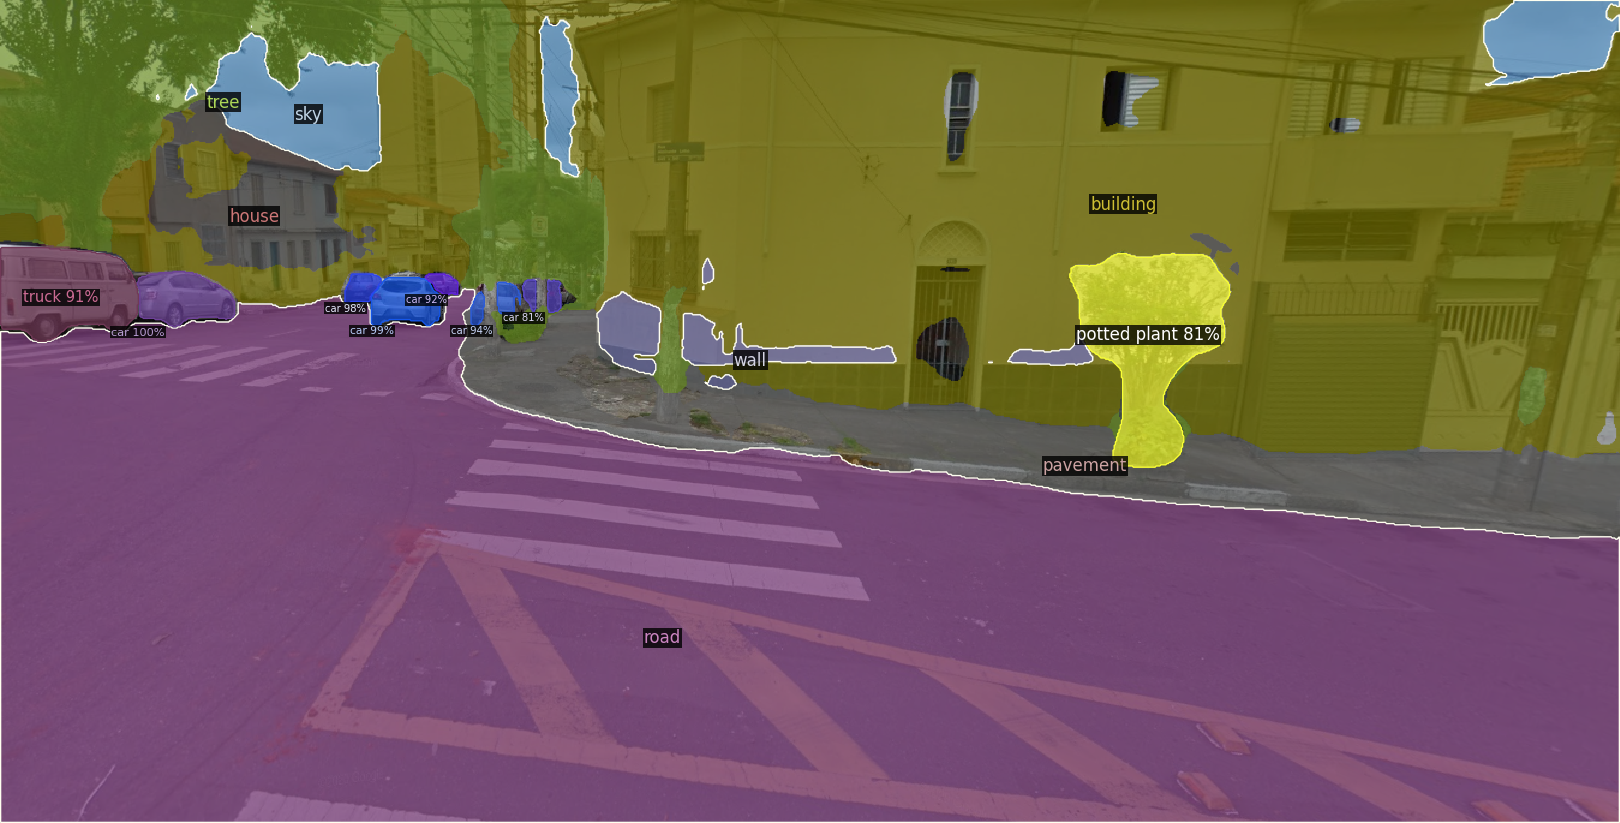

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
print(panoptic_seg)
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
print(panoptic_seg.shape)
print(panoptic_seg[350][680])

torch.Size([686, 1350])
tensor(13, dtype=torch.int32)


In [ ]:
%cd sidewalk_depthanything/

/content/sidewalk_depthanything


In [ ]:
import argparse
import cv2
import numpy as np
import os
import torch
import torch.nn.functional as F

from sidewalk_depthanything.pixel_size import pixel_sum
from torchvision.transforms import Compose
from tqdm import tqdm
from sidewalk_depthanything.depth_anything.dpt import DepthAnything
from sidewalk_depthanything.depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

import sys
for idx, arg in enumerate(sys.argv):
    if arg == '-f':
        sys.argv.pop(idx)
        sys.argv.pop(idx)

parser = argparse.ArgumentParser(allow_abbrev=False)
parser.add_argument('--img-path', type=str, default='assets/examples')
parser.add_argument('--outdir', type=str, default='depth_vis')
parser.add_argument('--encoder', type=str, default='vitl', choices=['vits', 'vitb', 'vitl'])
parser.add_argument('--pred-only', dest='pred_only', action='store_true', help='only display the prediction')
parser.add_argument('--grayscale', dest='grayscale', action='store_true', help='do not apply colorful palette')
args = parser.parse_args()

margin_width = 50
caption_height = 60

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_thickness = 2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(args.encoder)
depth_anything = DepthAnything.from_pretrained('LiheYoung/depth_anything_{}14'.format(args.encoder)).to(DEVICE).eval()

total_params = sum(param.numel() for param in depth_anything.parameters())
print('Total parameters: {:.2f}M'.format(total_params / 1e6))

transform = Compose([
  Resize(
      width=518,
      height=518,
      resize_target=False,
      keep_aspect_ratio=True,
      ensure_multiple_of=14,
      resize_method='lower_bound',
      image_interpolation_method=cv2.INTER_CUBIC,
  ),
  NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  PrepareForNet(),
])

focal_length = 5

if os.path.isfile(args.img_path):
  if args.img_path.endswith('txt'):
      with open(args.img_path, 'r') as f:
          filenames = f.read().splitlines()
  else:
      filenames = [args.img_path]
else:
  filenames = os.listdir(args.img_path)
  filenames = [os.path.join(args.img_path, filename) for filename in filenames if not filename.startswith('.')]
  filenames.sort()

os.makedirs(args.outdir, exist_ok=True)

for filename in tqdm(filenames):
  raw_image = cv2.imread(filename)
  image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB) / 255.0

  h, w = image.shape[:2]

  image = transform({'image': image})['image']
  image = torch.from_numpy(image).unsqueeze(0).to(DEVICE)

  with torch.no_grad():
      depth = depth_anything(image)

  depth = F.interpolate(depth[None], (h, w), mode='bilinear', align_corners=False)[0, 0]
  depth = (depth - depth.min()) / (depth.max() - depth.min()) * 255.0

  depth = depth.cpu().numpy().astype(np.uint8)

  physical_depth = focal_length / depth.astype(np.float32)

  object_width_pixels = 100
  object_width_cm = object_width_pixels * physical_depth / focal_length

  np.set_printoptions(threshold=np.inf, linewidth=np.inf)

  if args.grayscale:
      depth = np.repeat(depth[..., np.newaxis], 3, axis=-1)
  else:
      depth = cv2.applyColorMap(depth, cv2.COLORMAP_INFERNO)

  filename = os.path.basename(filename)

  if args.pred_only:
      cv2.imwrite(os.path.join(args.outdir, filename[:filename.rfind('.')] + '_depth.png'), depth)
  else:
      split_region = np.ones((raw_image.shape[0], margin_width, 3), dtype=np.uint8) * 255
      combined_results = cv2.hconcat([raw_image, split_region, depth])

      caption_space = np.ones((caption_height, combined_results.shape[1], 3), dtype=np.uint8) * 255
      captions = ['Raw image', 'Depth Anything']
      segment_width = w + margin_width

      for i, caption in enumerate(captions):
          text_size = cv2.getTextSize(caption, font, font_scale, font_thickness)[0]

          text_x = int((segment_width * i) + (w - text_size[0]) / 2)

          cv2.putText(caption_space, caption, (text_x, 40), font, font_scale, (0, 0, 0), font_thickness)

      final_result = cv2.vconcat([caption_space, combined_results])

      cv2.imwrite(os.path.join(args.outdir, filename[:filename.rfind('.')] + '_img_depth.png'), final_result)
  sum_first_row = np.sum(object_width_cm[0])

  # print("Primeiro vetor:", str(object_width_cm[0]))
  # print("Largura estimada do objeto em cm:", object_width_cm)
  # print("Distancia do começo ao final da imagem:" + str(pixel_sum(object_width_cm[200])))


vitl


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Total parameters: 335.32M


  0%|          | 0/1 [00:00<?, ?it/s]<ipython-input-8-1a9265b45fe7>:89: RuntimeWarning: divide by zero encountered in divide
  physical_depth = focal_length / depth.astype(np.float32)
100%|██████████| 1/1 [00:02<00:00,  2.06s/it]

Distancia do começo ao final da imagem:5874.381532669067


In [ ]:

# Criando uma máscara booleana onde panoptic_seg é igual a 13
mask = panoptic_seg == 13

# Usando a máscara para somar os valores de object_width_cm onde a máscara é True
soma = np.sum(object_width_cm[mask])

print("Soma dos valores de object_width_cm onde panoptic_seg é igual a 13:", soma)


Soma dos valores de object_width_cm onde panoptic_seg é igual a 13: 71429.11
